In [1]:
import h5py
import time
import datetime
import calendar
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
import tensorflow as tf

from functools import partial
from google.colab import drive
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate
from keras.layers import LSTM, Conv1D, MaxPooling1D, Bidirectional, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

sns.set()
warnings.filterwarnings("ignore")
drive.mount('/content/drive/')
print (tf.test.gpu_device_name())

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/device:GPU:0


# Feature Engineering, Data Preprocessing & Extraction

**Feature Engineering**

In [0]:
df = pd.read_excel("/content/drive/My Drive/Colab/Research - Load Forecasting/GEFCom2014-E.xlsx")
df = df.dropna(axis = 0) # Remove rows with NaN data (2004-01-01 to 2005-12-31)
df = df.reset_index(drop = True) # Replace the previous index with new index

df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d") # Specify the format of entry date
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Weekday"] = df["Date"].dt.weekday + 1 # To adjust to 1 to 7 instead of 0 to 6
df["Week"] = df["Day"].apply(lambda x: (x - 1) // 7 + 1)
df["Weekend"] = df["Weekday"].apply(lambda x: 1 if x >= 6 else 0) # Apply function to the column (default: axis=0)

In [0]:
# Find last Monday for holiday
def last_mon_date(year, month):
  
  """
  Returns a matrix representing a month’s calendar
  Each row represents a week; days outside of the month a represented by zeros
  Each week begins with Monday
  """
  cal = calendar.monthcalendar(year, month)
  last_mon_date = cal[4][0] if (cal[4][0] > 0) else cal[3][0]
  
  return str(year)+"-"+str(month)+"-"+str(last_mon_date)

unique_year = df["Year"].unique()
last_mon_may = []

for i in range(0, unique_year.shape[0], 1):
  last_mon_may.append(last_mon_date(unique_year[i], 5))
  
# Convert to timestamp
last_mon_may = [time.mktime(datetime.datetime.strptime(x,"%Y-%m-%d").timetuple()) for x in last_mon_may]

In [4]:
# Find holidays - total number of holidays = 9 * 10 * 24 (years*days*hours) = 2160
df["Holiday"] = 0
df["Holiday"] = df["Date"].apply(lambda x: 1 if (datetime.datetime.timestamp(x) in last_mon_may) else 0)
df["Holiday"].loc[(df["Month"] == 1) & (df["Day"] == 1)] = 1 # Remember () for condition
df["Holiday"].loc[(df["Month"] == 12) & (df["Day"] == 25)] = 1
df["Holiday"].loc[(df["Month"] == 11) & (df["Day"] == 11)] = 1
df["Holiday"].loc[(df["Month"] == 7) & (df["Day"] == 4)] = 1
df["Holiday"].loc[(df["Month"] == 1) & (df["Week"] == 3) & (df["Weekday"] == 1)] = 1
df["Holiday"].loc[(df["Month"] == 2) & (df["Week"] == 3) & (df["Weekday"] == 1)] = 1 
df["Holiday"].loc[(df["Month"] == 11) & (df["Week"] == 4) & (df["Weekday"] == 4)] = 1
df["Holiday"].loc[(df["Month"] == 10) & (df["Week"] == 2) & (df["Weekday"] == 1)] = 1
df["Holiday"].loc[(df["Month"] == 9) & (df["Week"] == 1) & (df["Weekday"] == 1)] = 1

print ("Total number for holidays: {} \n".format(np.sum(df["Holiday"])))

Total number for holidays: 2160 



In [5]:
df_backup = df.copy()

df.head()

,Date,Hour,load,T,Year,Month,Day,Weekday,Week,Weekend,Holiday
0,2006-01-01,1,3010.0,22.666667,2006,1,1,7,1,1,1
1,2006-01-01,2,2853.0,20.666667,2006,1,1,7,1,1,1
2,2006-01-01,3,2758.0,21.333333,2006,1,1,7,1,1,1
3,2006-01-01,4,2705.0,19.000000,2006,1,1,7,1,1,1
4,2006-01-01,5,2709.0,19.333333,2006,1,1,7,1,1,1


**Data Preprocessing**

In [0]:
# Select 2006-2009 data for training, 2010 for validation and 2011 for testing
train_index = (min(df.loc[df["Year"] == 2006].index), max(df.loc[df["Year"] == 2009].index))
valid_index = (min(df.loc[df["Year"] == 2010].index), max(df.loc[df["Year"] == 2010].index))
test_index = (min(df.loc[df["Year"] == 2011].index), max(df.loc[df["Year"] == 2011].index))

In [0]:
# Standardize after splitting to prevent leakage of data
sc_load = MinMaxScaler()
sc_temp = MinMaxScaler()

df_train = df.iloc[train_index[0]:train_index[1] + 1, :].copy()
df_valid = df.iloc[valid_index[0]:valid_index[1] + 1, :].copy()
df_test = df.iloc[test_index[0]:test_index[1] + 1, :].copy()

df_train.iloc[:, 2:3] = sc_load.fit_transform(df_train.iloc[:, 2:3])
df_valid.iloc[:, 2:3] = sc_load.transform(df_valid.iloc[:, 2:3])
df_test.iloc[:, 2:3] = sc_load.transform(df_test.iloc[:, 2:3])

df_train.iloc[:, 3:4] = sc_temp.fit_transform(df_train.iloc[:, 3:4])
df_valid.iloc[:, 3:4] = sc_temp.transform(df_valid.iloc[:, 3:4])
df_test.iloc[:, 3:4] = sc_temp.transform(df_test.iloc[:, 3:4])

**Data Extraction**

In [0]:
# 5 weeks of lagged observation
timesteps = 5 * 7 * 24 

def extract_data(timesteps, df):
  
  last_timesteps = len(df)
  
  # Sequential data - 5 weeks of past observed load and temperature
  load_temp = df.iloc[:, 2:4].values
  x_seq = []
  y = []
  for i in range (timesteps, last_timesteps, 1):
    x_seq.append(load_temp[i - timesteps:i, :])
    y.append(load_temp[i, 0])
  x_seq = np.array(x_seq)
  # Observations, timesteps, indicators  
  x_seq = np.reshape(x_seq, (x_seq.shape[0], x_seq.shape[1], x_seq.shape[2]))
  y = np.array(y)
  y = np.reshape(y, (y.shape[0], 1))
  
  load_features = []
  temp_features = []
  for i in range (0, timesteps):
    load_features.append("Load_{}".format(i - 840))
    temp_features.append("Temp_{}".format(i - 840))                             
  load_features = np.array(load_features)
  temp_features = np.array(temp_features)
 
  # Normal data - one-hot encoded  
  df = pd.get_dummies(df.iloc[timesteps:last_timesteps, :], columns=['Hour', 'Weekday', 'Week', 'Weekend', 'Holiday'], drop_first = True)
  df = df.drop(['Date', 'load', 'T', 'Year', 'Month', 'Day'], axis = 1)
  x = df.values
  
  # Features
  features = np.concatenate((load_features, temp_features, df.columns.values))
  
  return x_seq, x, y, features

x_seq_train, x_train, y_train, features = extract_data(timesteps, df_train)
x_seq_valid, x_valid, y_valid, _ = extract_data(timesteps, df_valid)
x_seq_test, x_test, y_test, _ = extract_data(timesteps, df_test)

In [9]:
# Sanity check
print ("Shape of x_seq: {}, {}, {}".format(x_seq_train.shape, x_seq_valid.shape, x_seq_test.shape))
print ("Shape of x: {}, {}, {}".format(x_train.shape, x_valid.shape, x_test.shape))

print ("Sanity Check: {}, {}, {}".format(x_seq_train[1000, 839, 0] == df_train.iloc[1000 + 839, 2], 
                                         y_train[375] == df_train.iloc[timesteps + 375, 2], 
                                         y_train[375] == x_seq_train[376, -1, 0]))
print ("Sanity Check: {}, {}".format(x_train[375, 0] == df_train.iloc[375, 9], 
                                     x_train[7505, 1] == df_train.iloc[7505, 10]))

Shape of x_seq: (34224, 840, 2), (7920, 840, 2), (7920, 840, 2)
Shape of x: (34224, 35), (7920, 35), (7920, 35)
Sanity Check: True, [ True], [ True]
Sanity Check: True, True


# Probabilistic Load Forecasting

**Quantile & Confidence Level**

In [0]:
upper_bound = 0.95
lower_bound = 0.05
confidence = 1 - (upper_bound - lower_bound)

**Evaluation Metrics**

In [0]:
# PICP: predicition interval coverage probability
# WS: winkler score
def evaluate_PICP_WS(y_pred_upper, y_pred_lower, y_test, confidence):
  
  # Reshape to 2D array for standardization
  y_pred_upper = np.reshape(y_pred_upper, (len(y_pred_upper), 1))
  y_pred_lower = np.reshape(y_pred_lower, (len(y_pred_lower), 1))
  
  y_pred_upper = sc_load.inverse_transform(y_pred_upper)
  y_pred_lower = sc_load.inverse_transform(y_pred_lower)
  y_test = sc_load.inverse_transform(y_test)
  
  # Ravel for ease of computation
  y_pred_upper = y_pred_upper.ravel()
  y_pred_lower = y_pred_lower.ravel()
  y_test = y_test.ravel()
  
  # Find out of bound indices for WS
  idx_oobl = np.where((y_test < y_pred_lower) > 0)
  idx_oobu = np.where((y_test > y_pred_upper) > 0)
  
  PICP = np.sum((y_test > y_pred_lower) & (y_test <= y_pred_upper)) / len(y_test) * 100
  WS = np.sum(np.sum(y_pred_upper - y_pred_lower) + 
              np.sum(2 * (y_pred_lower[idx_oobl[0]] - y_test[idx_oobl[0]]) / confidence) +
              np.sum(2 * (y_test[idx_oobu[0]] - y_pred_upper[idx_oobu[0]]) / confidence)) / len(y_test)
  
  print ("PICP of testing set: {:.2f}%".format(PICP))
  print ("WS of testing set: {:.2f}".format(WS))
  
  return PICP, WS

In [0]:
def plot_feature_importance(model, features):
  
  num_features = 25 
  # Normalize (lightgbm returns importances_ not in form of percentage)
  importance = model.feature_importances_/sum(model.feature_importances_)
  idx = np.argsort(importance)[::-1][:num_features]
  
  fig, ax1 = plt.subplots(figsize=(10, 5))
  
  # Primary axis
  ax1.bar(x = np.arange(0, num_features), height = importance[idx])
  ax1.set_xticks(ticks = np.arange(0, num_features))
  ax1.set_xticklabels(features[idx], rotation = 45) #, rotation_mode="anchor")
  ax1.set_xlabel("Features")
  ax1.set_ylabel("Importance")
  ax1.set_title('Important Features')
  
  # Secondary axis
  ax2 = ax1.twinx()
  ax2.plot(np.cumsum(importance[idx]), 'ro-')
  ax2.set_ylabel("Accumulative Importance")
  plt.show()

def plot_quantile(y_pred_upper, y_pred_lower, y_test):
  
  # Reshape to 2D array for standardization
  y_pred_upper = np.reshape(y_pred_upper, (len(y_pred_upper), 1))
  y_pred_lower = np.reshape(y_pred_lower, (len(y_pred_lower), 1))
  
  y_pred_upper = sc_load.inverse_transform(y_pred_upper)
  y_pred_lower = sc_load.inverse_transform(y_pred_lower)
  y_test = sc_load.inverse_transform(y_test)
  
  fig, ax = plt.subplots(1, 1, figsize = (10, 5))
  ax.plot(y_test[:120], label = "Actual")
  ax.plot(y_pred_upper[:120], label = "95%")
  ax.plot(y_pred_lower[:120], label = "5%")
  ax.fill_between(np.arange(0, 120), y_pred_upper[0:120].ravel(), 
                  y_pred_lower[0:120].ravel(), color = "y", label = "90% PI")
  ax.set_title("Quantile Regession")
  ax.set_xlabel("Hour")
  ax.set_ylabel("Normalized Load (pu)")
  ax.legend()
  plt.show()

# Stack data for gradient boosting, xgboost and lightgbm
def stack_data(x_seq, x):
  
  load = x_seq[:,:,0]
  temp = x_seq[:,:,1]
  
  x_stack = np.hstack((load, temp, x))
  
  return x_stack

In [13]:
x_stack_train = stack_data(x_seq_train, x_train)
x_stack_valid = stack_data(x_seq_valid, x_valid)
x_stack_test = stack_data(x_seq_test, x_test)

# Sanity check
print ("Shape of x_stack: {}, {}, {}".format(x_stack_train.shape, x_stack_valid.shape, x_stack_test.shape))

Shape of x_stack: (34224, 1715), (7920, 1715), (7920, 1715)


**Gradient Boosting**

In [0]:
"""
1. alpha: the quantile for prediction (multiple runs for different quantile)
2. subsample: fraction of samples for fitting, lower fraction leads to a 
              reduction of variance with an increase in bias
3. max_features: the number of features considered for best split, lower fraction
                 has the same effect as subsample
"""

# Tuned hyperparameter - n_estimators, learning_rate

# 95% quantile
GBR = GradientBoostingRegressor(loss = "quantile", alpha = upper_bound, learning_rate = 0.1, n_estimators = 250, 
                               subsample = 1.0, max_features = 1.0, min_samples_split = 2, 
                               min_samples_leaf = 1, verbose = 1) #, max_depth = 3, max_leaf_nodes = 8)
GBR.fit(x_stack_train, y_train)

with open ("/content/drive/My Drive/Colab/Research - Load Forecasting/GBR_95", "wb") as file:
  pickle.dump(GBR, file)

# 5% quantile
GBR.set_params(alpha = lower_bound)
GBR.fit(x_stack_train, y_train)

with open ("/content/drive/My Drive/Colab/Research - Load Forecasting/GBR_5", "wb") as file:
  pickle.dump(GBR, file)

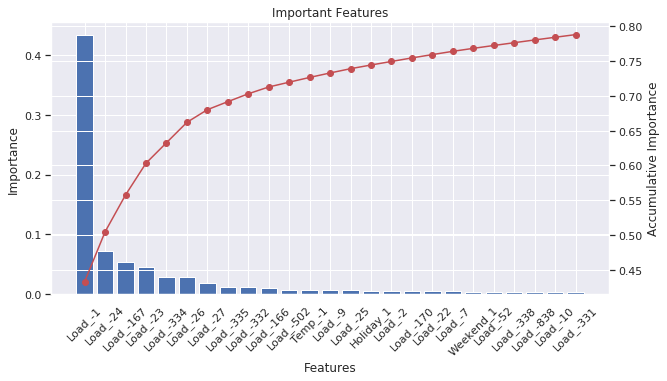

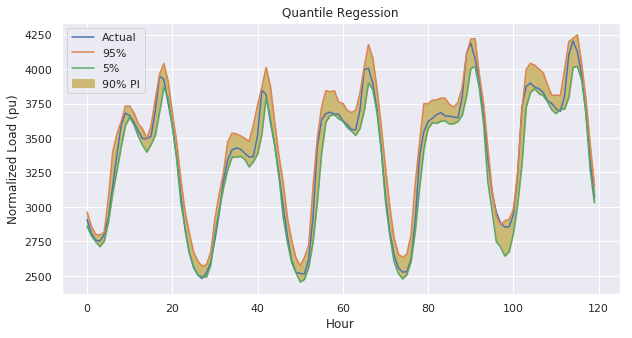

PICP of testing set: 85.42%
WS of testing set: 250.36
Training time taken: 50.61m


In [83]:
# Result
with open ("/content/drive/My Drive/Colab/Research - Load Forecasting/GBR_95", "rb") as file:
  GBR_95 = pickle.load(file)

with open ("/content/drive/My Drive/Colab/Research - Load Forecasting/GBR_5", "rb") as file:
  GBR_5 = pickle.load(file)

y_pred_95 = GBR_95.predict(x_stack_test)

y_pred_5 = GBR_5.predict(x_stack_test)

plot_feature_importance(GBR_5, features)
plot_quantile(y_pred_95, y_pred_5, y_test)

PICP, WS = evaluate_PICP_WS(y_pred_95, y_pred_5, y_test, confidence = confidence)
print ("Training time taken: 50.61m")

**XGBoost**

[00:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


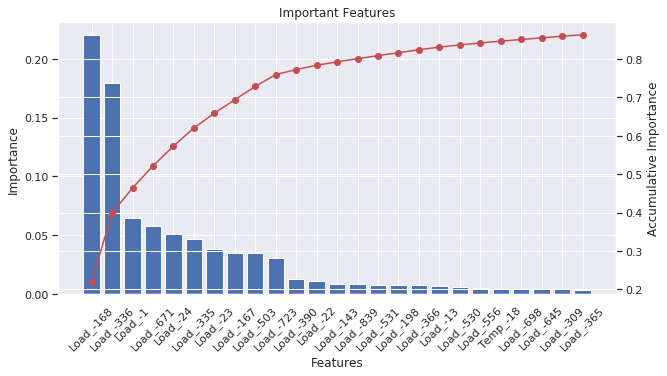

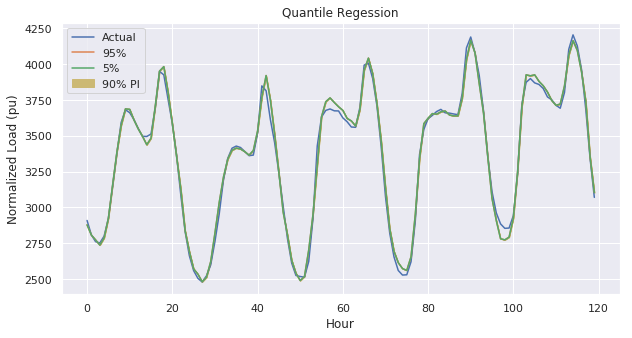

In [0]:
# Point forecasting
def loss(y_true, y_pred):
  
  grad = -(y_true - y_pred)
  
  hess = 1 * np.ones(grad.shape)
  
  return grad, hess

objective = partial(loss)

XGBR = XGBRegressor(max_depth = 3, learning_rate = 0.1, n_estimators = 250, 
                    verbosity = 1, silent = None, objective = objective, 
                    booster = 'gbtree', n_jobs = 1, nthread = None, gamma = 0, 
                    min_child_weight = 1, max_delta_step = 0, subsample = 1, 
                    colsample_bytree = 1, colsample_bylevel = 1, colsample_bynode = 1, 
                    reg_alpha = 0, reg_lambda = 1, scale_pos_weight = 1, 
                    base_score = 0.5, random_state = 0, seed = None, missing = None,
                    importance_type = 'gain')

XGBR.fit(x_stack_train, y_train)

y_pred_95 = XGBR.predict(x_stack_test)

plot_feature_importance(XGBR, features)
plot_quantile(y_pred_95, y_pred_95, y_test)

In [0]:
# Xgboost does not support quantile regression, customized loss function is required
# Return gradient and hessian of loss function to determine the split and loss
# https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html

# Tuned hyperparameter - hess
# Hess controls splits and prevents underfitting

# Function arguments with default value have to be at the end
# Pinball loss/ quantile score for single quantile
def tilted_loss(y_true, y_pred, quantile):

  """
  Xgboost requires loss function to have non-zero Hessian, however second order 
  differentiation of tilted loss function is zero -> Hessian is zero, thus in 
  this case it is set to be a constant (hyperparameter) to fulfill the requirement
  (https://github.com/dmlc/xgboost/issues/1825)
  """

  e = y_true - y_pred
  grad = (1 - quantile) * (e < 0) + (-quantile) * (e >= 0)
  hess = 4 * np.ones(grad.shape)

  return grad, hess

# Pinball loss/ quantile score of single quantile for validation
def tilted_loss_valid(y_true, y_pred, quantile):

  e = y_true - y_pred
  
  # find the sum of loss of quantile
  return np.sum(np.maximum(quantile * e, (quantile - 1) * e)) 

In [0]:
start = time.time()

# Tuned hyperparameter - n_estimators, learning_rate, reg_alpha 
# Reg_alpha controls LI regularization loss and prevents overfitting
# Both hess & reg-alpha to be tuned appropriately

# 95% quantile
# https://stackoverflow.com/questions/26182068/typeerror-got-multiple-values-for-argument-after-applying-functools-partial
# Function arguments with default value have to be at the end
objective = partial(tilted_loss, quantile = np.array([upper_bound])) 

XGBR = XGBRegressor(max_depth = 3, learning_rate = 0.1, n_estimators = 250, 
                    verbosity = 1, silent = None, objective = objective, 
                    booster = 'gbtree', n_jobs = 1, nthread = None, gamma = 0, 
                    min_child_weight = 1, max_delta_step = 0, subsample = 1, 
                    colsample_bytree = 1, colsample_bylevel = 1, colsample_bynode = 1, 
                    reg_alpha = 5, reg_lambda = 1, scale_pos_weight = 1, 
                    base_score = 0.5, random_state = 0, seed = None, missing = None,
                    importance_type = 'gain')
XGBR.fit(x_stack_train, y_train)

with open ("/content/drive/My Drive/Colab/Research - Load Forecasting/XGBR_95", "wb") as file:
  pickle.dump(XGBR, file)

# 5% quantile
objective = partial(tilted_loss, quantile = np.array([lower_bound]))

XGBR.set_params(objective = objective)
XGBR.fit(x_stack_train, y_train)

with open ("/content/drive/My Drive/Colab/Research - Load Forecasting/XGBR_5", "wb") as file:
  pickle.dump(XGBR, file)

end = time.time()

[04:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


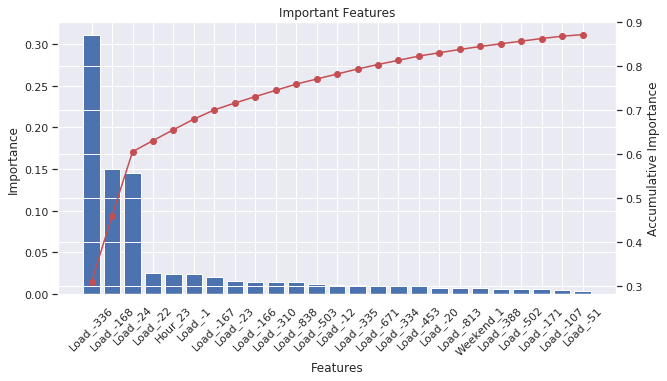

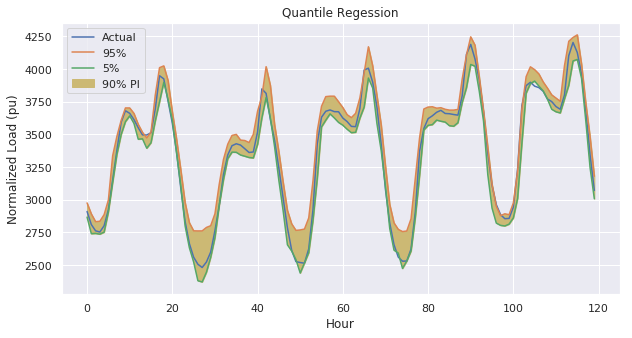

PICP of testing set: 84.60%
WS of testing set: 283.68
Training time taken: 6.22m


In [84]:
# Result
with open ("/content/drive/My Drive/Colab/Research - Load Forecasting/XGBR_95", "rb") as file:
  XGBR_95 = pickle.load(file)

with open ("/content/drive/My Drive/Colab/Research - Load Forecasting/XGBR_5", "rb") as file:
  XGBR_5 = pickle.load(file)

y_pred_95 = XGBR_95.predict(x_stack_test)

y_pred_5 = XGBR_5.predict(x_stack_test)

plot_feature_importance(XGBR_5, features)
plot_quantile(y_pred_95, y_pred_5, y_test)

PICP, WS = evaluate_PICP_WS(y_pred_95, y_pred_5, y_test, confidence = confidence)
print ("Training time taken: {:.2f}m".format((end - start) / 60))

**LightGBM**

In [105]:
"""
There is in-built quantile loss function but similar way as xgboost can be used
to declare loss function (returns grad, hessian) and evaluation metrics 
(return loss)
https://medium.com/the-artificial-impostor/quantile-regression-part-2-6fdbc26b2629
"""

# 1D array label required for LightGBM package
# https://stackoverflow.com/questions/45140488/proper-label-type-assignment-while-working-with-lightgbm-package-in-python

start = time.time()

# Tuned hyperparameter - n_estimators, learning_rate, reg_alpha

# 95% quantile

LGBR = LGBMRegressor(boosting_type = 'gbdt', num_leaves = 31, max_depth = -1, 
                     learning_rate = 0.1, n_estimators = 250, objective = 'quantile', 
                     alpha = upper_bound, class_weight = None, min_split_gain = 0.0, 
                     min_child_weight = 0.001, min_child_samples = 20, 
                     subsample_for_bin = 200000, subsample = 1.0,
                     subsample_freq = 0, colsample_bytree = 1.0, reg_alpha = 10.0, 
                     reg_lambda = 1.0, random_state = None, n_jobs = -1, silent = True, 
                     importance_type = 'split')

LGBR.fit(x_stack_train, y_train.ravel(), eval_set = [(x_stack_train, y_train.ravel()), (x_stack_valid, y_valid.ravel())], 
         eval_metric = 'quantile', early_stopping_rounds = 20, verbose = 25)

with open ("/content/drive/My Drive/Colab/Research - Load Forecasting/LGBR_95", "wb") as file:
  pickle.dump(LGBR, file)

# 5% quantile
LGBR.set_params(alpha = lower_bound)
LGBR.fit(x_stack_train, y_train.ravel(), eval_set = [(x_stack_train, y_train.ravel()), (x_stack_valid, y_valid.ravel())], 
         eval_metric = 'quantile', early_stopping_rounds = 20, verbose = 25)

with open ("/content/drive/My Drive/Colab/Research - Load Forecasting/LGBR_5", "wb") as file:
  pickle.dump(LGBR, file)
  
end = time.time()

Training until validation scores don't improve for 20 rounds.
[25]	valid_0's quantile: 0.00750025	valid_1's quantile: 0.00810468
[50]	valid_0's quantile: 0.00467664	valid_1's quantile: 0.00519851
[75]	valid_0's quantile: 0.00292375	valid_1's quantile: 0.00345159
[100]	valid_0's quantile: 0.00200149	valid_1's quantile: 0.0025356
[125]	valid_0's quantile: 0.00151732	valid_1's quantile: 0.00205978
[150]	valid_0's quantile: 0.00127792	valid_1's quantile: 0.00183725
[175]	valid_0's quantile: 0.00115196	valid_1's quantile: 0.00173089
[200]	valid_0's quantile: 0.00108001	valid_1's quantile: 0.00168757
[225]	valid_0's quantile: 0.00102917	valid_1's quantile: 0.00166226
[250]	valid_0's quantile: 0.000995622	valid_1's quantile: 0.00165264
Did not meet early stopping. Best iteration is:
[250]	valid_0's quantile: 0.000995622	valid_1's quantile: 0.00165264
Training until validation scores don't improve for 20 rounds.
[25]	valid_0's quantile: 0.00816807	valid_1's quantile: 0.00786891
[50]	valid_0's 

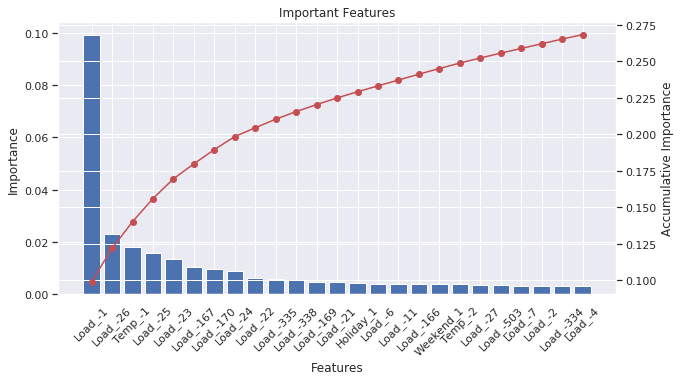

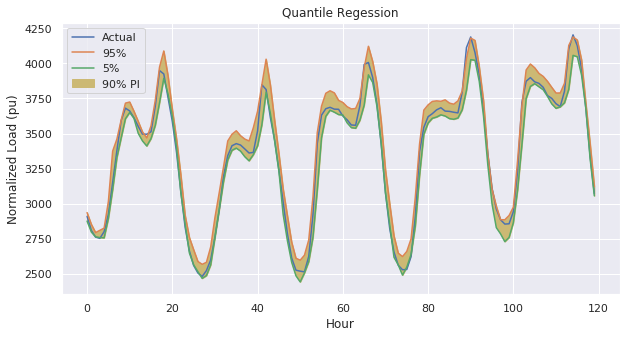

PICP of testing set: 77.32%
WS of testing set: 231.67
Training time taken: 6.04m


In [106]:
# Result
with open ("/content/drive/My Drive/Colab/Research - Load Forecasting/LGBR_95", "rb") as file:
  LGBR_95 = pickle.load(file)

with open ("/content/drive/My Drive/Colab/Research - Load Forecasting/LGBR_5", "rb") as file:
  LGBR_5 = pickle.load(file)

y_pred_95 = LGBR_95.predict(x_stack_test, num_iteration = LGBR_95.best_iteration_)

y_pred_5 = LGBR_5.predict(x_stack_test, num_iteration = LGBR_5.best_iteration_)

plot_feature_importance(LGBR_5, features)
plot_quantile(y_pred_95, y_pred_5, y_test)

PICP, WS = evaluate_PICP_WS(y_pred_95, y_pred_5, y_test, confidence = confidence)
print ("Training time taken: {:.2f}m".format((end - start) / 60))

**Neural Networks**

In [0]:
class NNQRegressor():
  
  def __init__(self, x_seq_train, x_seq_valid, x_seq_test, x_train, x_valid, 
               x_test, y_train, y_valid, y_test, timesteps, quantiles):
    
    self.x_seq_train = x_seq_train
    self.x_seq_valid = x_seq_valid
    self.x_seq_test = x_seq_test
    self.x_train = x_train
    self.x_valid = x_valid
    self.x_test = x_test    
    self.y_train = y_train
    self.y_valid = y_valid
    self.y_test = y_test
    self.epochs = 100
    self.batch_size = 512
    self.timesteps = timesteps
    self.quantiles = quantiles
    self.num_quantiles = len(self.quantiles)
    self.best_weight_dir = "/content/drive/My Drive/Colab/Research - Load Forecasting/best_weights_NNQR.hdf5"
    self.model = self.create_model()
  
  def create_model(self):
    
    input_seq_load = Input(shape = (self.timesteps, 1), name = "input_seq_load")
    x1 = Conv1D(64, kernel_size = 3, strides = 1, padding = "same", activation = "elu")(input_seq_load)
    x1 = MaxPooling1D(pool_size = 2, strides = 2, padding = "same")(x1)
    x1 = LSTM(64, return_sequences = False, return_state = False)(x1)

    input_seq_temp = Input(shape = (self.timesteps, 1), name = "input_seq_temp")
    x2 = Conv1D(64, kernel_size = 3, strides = 1, padding = "same", activation = "elu")(input_seq_temp)
    x2 = MaxPooling1D(pool_size = 2, strides = 2, padding = "same")(x2)
    x2 = LSTM(64, return_sequences = False, return_state = False)(x2)

    input_normal = Input(shape = (self.x_train.shape[1], ), name = "input_normal")

    x3 = concatenate([x1, x2, input_normal], axis = -1)
    x3 = Dense(64, activation = "elu")(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(32, activation = "elu")(x3)
    x3 = Dropout(0.2)(x3)
    output = Dense(self.num_quantiles, activation = "linear")(x3)

    model = Model(inputs = [input_seq_load, input_seq_temp, input_normal], outputs = [output])
    # loss = partial(self.tilted_loss, quantiles = self.quantiles) (The other way of declaring loss)
    model.compile(loss = [lambda y_true, y_pred: self.tilted_loss(y_true, y_pred, self.quantiles)], 
                  optimizer = "adam")
    model.summary()
    
    return model  
  
  # Function arguments with default value have to be at the end
  # Pinball loss/ quantile score for multiple or single quantile
  def tilted_loss(self, y_true, y_pred, quantiles):
    
    y_true = K.cast(y_true, "float32")
    y_pred = K.cast(y_pred, "float32")
    e = y_true - y_pred
    
    # find the sum of average loss of each quantile
    return K.sum(K.mean(K.maximum(quantiles * e, (quantiles - 1) * e), axis = 0)) 
  
  def train(self):
    
    model_checkpoint = ModelCheckpoint(self.best_weight_dir, monitor = "val_loss", 
                                       save_best_only = True, save_weights_only = True,
                                       verbose = 1)
    early_stopping = EarlyStopping(monitor = "val_loss", patience = 20)
    callbacks = [model_checkpoint, early_stopping]
    
    input_train_lib = {"input_seq_load": np.reshape(self.x_seq_train[:,:,0], (x_seq_train.shape[0], x_seq_train.shape[1], 1)), 
                       "input_seq_temp": np.reshape(self.x_seq_train[:,:,1], (x_seq_train.shape[0], x_seq_train.shape[1], 1)),
                       "input_normal": self.x_train}
    input_valid_lib = {"input_seq_load": np.reshape(self.x_seq_valid[:,:,0], (x_seq_valid.shape[0], x_seq_valid.shape[1], 1)), 
                       "input_seq_temp": np.reshape(self.x_seq_valid[:,:,1], (x_seq_valid.shape[0], x_seq_valid.shape[1], 1)), 
                       "input_normal": self.x_valid}
    ones = np.ones((self.num_quantiles))
    
    self.history = self.model.fit(input_train_lib, self.y_train * ones,
                                  validation_data = (input_valid_lib, self.y_valid * ones), 
                                  callbacks = callbacks, epochs = self.epochs, 
                                  batch_size = self.batch_size, verbose = 1)

  def result(self):
    
    self.model.load_weights(self.best_weight_dir)

    input_test_lib = {"input_seq_load": np.reshape(self.x_seq_test[:,:,0], (x_seq_test.shape[0], x_seq_test.shape[1], 1)), 
                      "input_seq_temp": np.reshape(self.x_seq_test[:,:,1], (x_seq_test.shape[0], x_seq_test.shape[1], 1)),
                      "input_normal": self.x_test}
    
    y_pred = self.model.predict(input_test_lib, batch_size = self.batch_size)
    
    fig, ax = plt.subplots(figsize=(10,5))

    ax.plot(self.history.history["loss"], color = "r", label = "training")
    ax.plot(self.history.history["val_loss"], color = "b", label = "validation")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.legend()
    plt.show()
    
    return y_pred

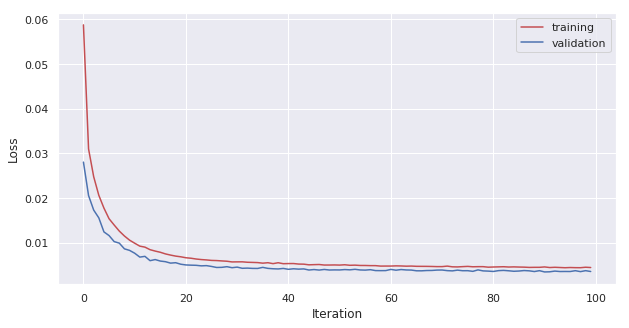

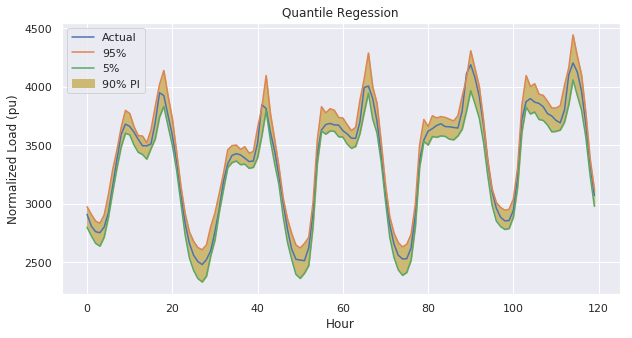

PICP of testing set: 97.49%
WS of testing set: 228.43
Training time taken: 158.91m


In [0]:
NNQR = NNQRegressor(x_seq_train, x_seq_valid, x_seq_test, x_train, x_valid, 
                    x_test, y_train, y_valid, y_test, timesteps, 
                    quantiles = np.array([upper_bound, lower_bound]))

start = time.time()
NNQR.train()
end = time.time()

y_pred = NNQR.result()
y_pred_95 = y_pred[:, 0]
y_pred_5 = y_pred[:, 1]

plot_quantile(y_pred_95, y_pred_5, y_test)

PICP, WS = evaluate_PICP_WS(y_pred_95, y_pred_5, y_test, confidence = confidence)
print ("Training time taken: {:.2f}m".format((end - start) / 60))

# Conclusion



1.   Performance - NN tends to overestimate the risk (PICP > PINC = 90%) while GB, XGB, LGB tend to understimate the risk; NN has the lowest winkler score
2. Training time - Although NN has the highest training time for 2 quantiles, it can be easily scaled to 99 quantiles by changing the number of outputs of NN. As compared to NN, all gradient boosting only supports single quantile which implies that the training time increases proportional to the number of quantiles required.
1.   All models either underestimate or overestimate the risk thus, direct prediction interval construction (DPIC) is not reliable (For example, upper bound of 95% and lower bound of 5% are chosen directly to construct prediction interval of 90%). The more appropriate method would be by adjusting upper and lower bound such that PICP is close to PINC as proposed in "[Parallel and reliable probabilistic load forecasting via quantile regression forest and quantile determination](https://www.sciencedirect.com/science/article/abs/pii/S0360544218313148)"



In [121]:
NN = np.array([97.49, 228.43, 158.91, 158.91])
GB = np.array([85.42, 250.36, 50.61, 2505.195])
XGB = np.array([84.6, 283.68, 6.22, 307.89])
LGB = np.array([77.32, 231.67, 6.04, 298.98])

index_name = ["PICP (%)", "WS", "Training Time for 2 quantiles (m)", 
              "Estimated Training Time for 99 quantiles (m)"]
result = pd.DataFrame(index = index_name, data = {"NN": NN, "GB": GB, "XGB": XGB, "LGB": LGB})

result

,NN,GB,XGB,LGB
PICP (%),97.49,85.420,84.60,77.32
WS,228.43,250.360,283.68,231.67
Training Time for 2 quantiles (m),158.91,50.610,6.22,6.04
Estimated Training Time for 99 quantiles (m),158.91,2505.195,307.89,298.98
